# Programming Coursework

#### Who are OpenPrescribing? 
>OpenPrescribing is a project built by EBM DataLab, funded by NHS England and NIHR Biomedical Research Centre, which aims to make medical and scientific information more accessible. The project collates a variety of medical data from the NHS including prescribing data, practice list sizes, clinical commision group information, practice locations and BNF codes. More information can be found at https://openprescribing.net/

#### What are BNF codes?
>BNF codes are unique identifiers for each drug which is prescribed in the NHS. The British National Formulary (BNF) maintain these codes and produces a hierarchial numbering system for drugs, grouped based on the drugs specific type. Openprescribing.net uses these codes to identify the number of drugs which have been prescribed by different practices. A list of all BNF sections can be found at https://openprescribing.net/bnf/

#### What are CCG codes?
>CCG codes identify the clinical commissioning groups across England, which replaced primary care trusts following the NHS health and social care act in 2012. These groups are responsible for the commissioning of health services in the area which they govern. More information can be found at https://www.nhscc.org/ccgs/

#### Our project
>Our project provides an interactive tool where users can produce graphs containing trends of prescribing over time, for particular medical practices across England. Users will provide input of a drug and clinical commissioning group (optionally, a practice within the specified clinical commissioning group may be input). The output will be a .png image file displaying a graph showing the highest prescribing practice of the specified drug within the specified CCG (normalised to practice list size), the average prescribing rate of a specified drug within the CCG, the lowest prescribing practice within the CCG, and if the optional practice input is given, the prescribing rate of the specified practice.

*Note: The jupyter notebook used to produce this markdown is present in the github directory as 'Submission.ipynb'. A second jupyter notebook, 'test.ipynb', contains the code used to conduct initial data and API exploration, experiment with a number of alternative plot designs and develop the final functions outlined below.* 

## 1) Loading python dependencies.

In [59]:
import requests # Import requests package to interact with openprescribing API.
import numpy as np # Import numpy as it is a dependency of pandas.
import pandas as pd # Import pandas for data manipulation and data frames.
import matplotlib.pyplot as plt # Import matplotlib for figure production.

# Set matplotlib size and display paramaters.
%matplotlib inline
plt.rcParams['figure.dpi'] = 100

## 2) Define the three custom functions devised for this project.

In [60]:
def makeName(CCG,BNF):
    '''
    Description: 
    
    makeName makes two API calls to the OpenPrescribing database and returns a list
    containing both the full name and code identifier for the best match CCG and BNF 
    identified from the specified input arguments. 
    
    Arguments:
    
    CCG     Clinicial Comissioning Group. This term can be specified as either an exact match
            to a CCG code (e.g. '14L') or as part of the full name of the CCG which will then
            be matched by the API (e.g 'manc' to match 'NHS Manchester CCG').
            
    BNF     British National Formulary reference to standard list of medicines used in UK prescribing.
            This term can be specified as either an exact match to a BNF code (e.g. '5.1' for 'Antibacterial
            Drugs') or as part of the full name of the BNF which will then be matched by the API (e.g.
            'antibacterial drugs').
    
    Details:
    
    OpenPrescribing have two information APIs that return details about all CCG or BNF sections
    matching a specified code or name. This function concatonates the user specified arguments with
    strings containing the other elements of the web addresses necessary for the API calls. Using
    the .get function of the Requests package, the API calls are made and checked for errors,
    and the results are coerced from .json into a pandas dataframe. The top row of the resultant 
    CCG and BNF data frames then contain the details of the best matching OpenPrescribing entries 
    for the users search term. The relevent code and full name of this entry is then returned by 
    the function as a list in the following format:
    
    [CCG CODE, CCG NAME, BNF CODE, BNF NAME]
    
    '''
    
    # Ensure the required packages are loaded
    # (Import requests and pandas packages).
    import requests
    import pandas as pd
    
    # Define an ApiError class to allow exceptions to be raised correctly.
    class ApiError(Exception):
        """An API Error Exception"""

        def __init__(self, status):
            self.status = status

        def __str__(self):
            return "APIError: status={}".format(self.status)
    
    # Define api components for later concatonation.
    linkapi = 'https://openprescribing.net'
    BNF_l = '/api/1.0/bnf_code/?q='
    CCG_l = '/api/1.0/org_code/?q='
    json = '&format=json'
    
    # Create complete api links by concatonating above strings with user specified input.
    # CCG link will retrieve both CCG name and code when either is specified. 
    CCG_link = linkapi + CCG_l + CCG + json
    # BNF link will retrieve both BNF name and code when either is specified.
    BNF_link = linkapi + BNF_l + BNF + json
    
    # Request from API using function from requests package. 
    CCG_request = requests.get(CCG_link)
    
    # Raise error if api does not return status 200.
    if CCG_request.status_code != 200:
        raise ApiError('{} (OpenPrescribing returned unsuitable status code)'.format(CCG_request.status_code))
    
    BNF_request = requests.get(BNF_link)
        
    # Raise error if api does not return status 200.
    if BNF_request.status_code != 200:
        raise ApiError('{} (OpenPrescribing returned unsuitable status code)'.format(BNF_request.status_code))    
    
    # Convert the json files returned from api to a data frame.
    CCG_data = pd.DataFrame(CCG_request.json())
    BNF_data = pd.DataFrame(BNF_request.json())
    
    # The api will return all entries that partially match user specified information.
    # The following will extract the CCG code & name and BNF id & name for the first returned entry (best match).
    output = [CCG_data['code'].iloc[0], CCG_data['name'].iloc[0],BNF_data['id'].iloc[0], BNF_data['name'].iloc[0]]
    
    # Return output list.
    return output

In [61]:
def getCombined(CCG, BNF):
    ''' 
    Description:
    
    getCombined makes two API calls to the OpenPrescribing database and returns a merged pandas
    data frame that contains: the last five years of data pertaining to the total spending and 
    number of prescription items for the specified BNF code by month for each practice within the 
    specified CCG; and the total list size (how many patients a practice covers) for each practice
    within the specified CCG.
    
    Arguments:
    
    CCG     Clinicial Comissioning Group. For this function, this term must be specified as an official
            CCG code (e.g. '14L' for 'NHS Manchester CCG').
            
    BNF     British National Formulary reference to standard list of medicines used in UK prescribing.
            For this function, this term must be specified as an exact match to a BNF code 
            (e.g. '5.1' for 'Antibacterial Drugs'). 
    
    Details:
    
    OpenPrescribing have a spending by practice API that allows information to be extracted for all centres
    within a particular CCG. This function first concatonates the provided CCG and BNF code arguments into 
    a web address with the correct structure to obtain this information. The API call is made using the
    the requests package, an error check is conducted to ensure the API is responsive, and the results
    are coerced from a .json file into a pandas dataframe. The output of this first API call contains 
    the actual cost and number of prescription items (for the specified BNF code) made each month over
    the last five years by each centre within the specified CCG.
    
    A second API provided by OpenPrescribing enables the total list size (how many patients a practice 
    covers) to be identified for each centre within a specified CCG. This function concatonates the provided
    CCG argument into a web address tailored for this API call. The call is then made using the requests 
    package and results coerced into a pandas data frame from .json. The output of this call contains the 
    total list size each month over the last five years for each centre within the specified CCG.
    
    Finally, this function sorts both data frames according to both date information and centre name
    and creates a merged data frame ensuring the date, centre name and centre ID of each row is 
    matched.
    
    '''
    
    # Ensure the required packages are loaded
    # (Import requests and pandas packages).
    import requests
    import pandas as pd
   
    # Define an ApiError class to allow exceptions to be raised correctly.
    class ApiError(Exception):
        """An API Error Exception"""

        def __init__(self, status):
            self.status = status

        def __str__(self):
            return "APIError: status={}".format(self.status)

    # Define api components for later concatonation.
    linkapi_1 = 'https://openprescribing.net/api/1.0/spending_by_practice/?'
    linkapi_2 = 'https://openprescribing.net/api/1.0/org_details/?org_type=practice'
    code = 'code='
    org = '&org='
    ex = '&keys=total_list_size'
    form = '&format=json'
    
    # Create complete api link by concatonating above strings with user specified input.
    firstcall = linkapi_1 + code + str(BNF) + org + CCG + form
    
    # Request from API using function from requests package. 
    prescription_data = requests.get(firstcall)
    
    # Raise error if api does not return status 200.
    if prescription_data.status_code != 200:
        raise ApiError('{} (OpenPrescribing returned unsuitable status code)'.format(prescription_data.status_code)) 
    
    # Create complete api link by concatonating above strings with user specified input.
    secondcall = linkapi_2 + org + CCG + ex + form
    
    # Request from API using function from requests package. 
    listsize_data = requests.get(secondcall)
    
    # Raise error if api does not return status 200.
    if listsize_data.status_code != 200:
        raise ApiError('{} (OpenPrescribing returned unsuitable status code)'.format(listsize_data.status_code)) 
        
    # Convert json to pandas data frame.
    prescription_data = pd.DataFrame(prescription_data.json())
    
    # Extract column names.
    columns = prescription_data.columns
    
    # Sort dataframe according to both date and practice name.
    prescription_data = prescription_data.sort_values([columns[2],columns[6]])
    
    # Convert second api call json to pandas.
    listsize_data = pd.DataFrame(listsize_data.json())
    
    # Sort dataframe according to both date and practice name.
    listsize_data = listsize_data.sort_values([columns[2],columns[6]])

    # Merge two api call dataframes together ensuring row_namne, date and row_ids match.
    combinedData = pd.merge(prescription_data, listsize_data, on=['row_name','date','row_id'])
   
    # Returm merged dataframe.
    return(combinedData)

In [79]:
def prescriptionsPlot(CCG='', BNF='', centre='', demomode=False):
    '''
    Description:
    
    prescriptionsPlot passes the provided CCG and BNF arguments to the makeName function. The validated
    CCG and BNF codes returned from the makeName function are then passed to the getCombined function
    to obtain a merged dataset ready for plotting. The function then returns a plot that displays the average
    and standard deviation number of prescriptions per 1000 people made for the specified BNF each month across
    all centres within the specified CCG. Additionally the plot displays the values for the two centres
    determined to prescribe on average the most and least prescriptions per 1000 people, respectively.
    
    Optionally, a complete or partial match to the name of a centre within the specified CCG can be provided
    to the function and the data relating to this centre is displayed as an additional line on the plot.
    
    The function includes a demomode (off by default) that allows a plot to be produced without making
    any API calls. 
    
    A .png of the plot is automatically saved when the function is excecuted.
    
    Note: The function uses information retrived from the makeName function and getCombined results tables 
    to populate the figure title and legend with both the full name and codes for the relevent CCG, BNF and 
    centres (CCG and BNF codes shown in title within brackets; centre codes shown in legend following colon).   
    
    Arguments:
    
    CCG       Clinicial Comissioning Group. This term can be specified as either an exact match
              to a CCG code (e.g. '14L') or as part of the full name of the CCG which will then
              be matched by the API (e.g 'manc' to match 'NHS Manchester CCG').
            
    BNF       British National Formulary reference to standard list of medicines used in UK prescribing.
              This term can be specified as either an exact match to a BNF code (e.g. '5.1' for 'Antibacterial
              Drugs') or as part of the full name of the BNF which will then be matched by the API (e.g.
              'antibacterial drugs').
            
    centre    An optional value to a specify a particular centre that falls within the specified CCG. If 
              defined, the number of prescriptions (for the speficied BNF) made each month by the selected
              centre are added as an additional line on the graph. This term can be specfied as either an 
              exact or partial match of the full name of the centre. If the specified centre name does 
              match an entry within the results from API calls made using the provided CCG and BNF 
              arguments, a warning message is shown and the provided centre information is ignored.
    
    demomode  Logical value that defaults to False. If True then the provided CCG and BNF arguments are ignored
              and an offline example data set pertaining to the NHS Manchester CCG and BNF = 'Antibacterial 
              Drugs' is loaded. An example plot is then generated using this dataset. Note: A centre can
              still be specfied to the function when in demomode as a centre match is made by examining 
              the entries within the results table and not through conducting further API calls. 
    
    Details:
    
    By default, this function first retrieves CCG and BNF details using the makeName function and obtains 
    relevent data for the number of BNF prescriptions and total list size each month for each centre within 
    the specified CCG using the getCombined function (See: help(makeName) and help(getCombined)). When 
    executed in demomode, the function loads an equivalent offline dataset pertaining to NHS Manchester 
    CCG and BNF = 'Antibacterial Drugs'.
    
    The function then normalises the number of prescription items made by each center per month to the number 
    of items per 1000 people. This is achieved by dividing the number of prescription items by the total
    list size and multiplying by one thousand. The two centes within the CCG that have prescribed on average 
    the most and least items, respectively, are identified by grouping rows according to centre name and
    locating the two centres with the largest and smallest mean prescriptions per 1000 people across 
    all months. The monthly prescription values for these two centres are then extracted and stored
    in new data frames. 
    
    Average and standard deviation values are computed by grouping rows according to date and determing the
    average and standard deviation items per 1000 people that took place each month across all centres. The
    monthly mean and standard deviation value are stored as a new data frame.
    
    If a centre argument is specified, the function searches for a partial match within the centre name
    column of the combined data set. The values pertaining to the best match centre name are extracted
    and stored as a new data frame. If no match is identified, an error message is produced and the
    provided centre argument is ignored. 
    
    Once all the relevent data has been obtained, normalised and extracted, the function produces a plot
    displaying the average (and standard deviation), maximum and minimum number of prescriptions
    delivered within the specified CCG that pertain to the specified BNF. The figure title and legend 
    is populated with the relevent CCG, BNF and centre names and codes. Lastly, the function exports a
    .pnf of the plot and names the file according to the plot title.
    
    '''
    
    # Ensure the required packages are loaded
    # (Import requests, pandas and matplotlib packages).
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    # If the demomode paramter of the function is set to True...
    if demomode:
        
        # Do not use API.
        # Ignore the provided CCG and BNF values and do not run 'makeName' or 'getCombined' functions.
        
        # Warn user that demomode is active.
        print('Demomode active!')
        print('Loading ExampleData.csv')
        print("Generating example plot: CCG = 'NHS Manchester CCG', BNF = 'Antibacterial Drugs'", end='')
        
        # Load the included example data set which relates to 
        # CCG='14L' (Manchester) and BNF='5.1' (Antibacterial Drugs).
        combined_data = pd.read_csv('ExampleData',index_col=0)
        
        # Set example CCG/BNF codes/names vector for plot lables.
        codes_names = ['14L', 'NHS MANCHESTER CCG', '5.1', 'Antibacterial Drugs']
        
    else:
        
        # Run makeName function using specified CCG and BNF input.
        codes_names = makeName(CCG,BNF)
    
        # Run combined_data function to retrieve both x and y information pertaining to specified CCG and BNF codes.
        combined_data = getCombined(codes_names[0],codes_names[2])
    
    # Ensure specified centre is in block capitals.
    centre = centre.upper()
    
    # Create column for prescrition items normalised by total list size.
    combined_data['itemsPP'] = combined_data['items']/combined_data['total_list_size']
    # Multiply normalised values to create data per 1000 people.
    combined_data['itemsP1000P'] = combined_data['itemsPP']*1000
    
    # Group data by centre name and compute average and std of items 
    items_data = combined_data['itemsP1000P'].groupby(combined_data['row_name']).describe()

    # Identify the centre with the max average number of prescription items across all months. 
    # Ensure centre has data for all 60 months.
    max_items = items_data[items_data['count']==60]['mean'].idxmax()
    max_items_id = combined_data[combined_data['row_name']==max_items]['row_id'].iloc[0]
    
    # Identify the centre with the lowest average number of prescription items across all months. 
    # Ensure centre has data for all 60 months.
    min_items = items_data[items_data['count']==60]['mean'].idxmin()
    min_items_id = combined_data[combined_data['row_name']==min_items]['row_id'].iloc[0]
    
    # Group data by date and compute average and std items per 1000 people for each date across all centres.
    mean_items_data = combined_data['itemsP1000P'].groupby(combined_data['date']).describe()
    
    # Extract number of items per 1000 people for each month for centre with highest average number of prescription items.
    max_centre = combined_data[combined_data['row_name'].str.contains(max_items)]
    
    # Extract number of items per 1000 people for each month for centre with lowest average number of prescription items.
    min_centre = combined_data[combined_data['row_name'].str.contains(min_items)]
    
    # Define subplot and figure size.
    fig, ax = plt.subplots(figsize=(20,10))
    
    # Add max centre plot to subplot: x axis = dates; y = axis prescription items per 1000 people. 
    # Set line color to red and label the line using the max_items label (append '(max)' string).
    ax.plot(max_centre['date'], max_centre['itemsP1000P'], color='red',label=max_items+': '+max_items_id+' (max)')
    
    # Add average of centres plot to subplot: x axis = dates; y axis = mean prescription items per 1000 people.
    # Set line color to black and label the line 'AVERAGE'.
    ax.plot(mean_items_data.index,mean_items_data['mean'], color='black',label='AVERAGE')
    
    # Add min centre plot to subplot: x axis = dates; y axis = prescription items per 1000 people. 
    # Set line color to green and label the line using the min_items label (append '(max)' string).
    ax.plot(min_centre['date'], min_centre['itemsP1000P'], color='green',label=min_items+': '+min_items_id+' (min)')
    
    # If a centre is specified...
    if centre:
        
        # Check a partial match for the specifed centre exists within the specified CCG.
        if len(combined_data[combined_data['row_name'].str.contains(centre)]) > 0:
            
            # Extract number of items per 1000 people for each month for the specified centre.
            custom_centre = combined_data[combined_data['row_name'].str.contains(centre)]

            # Extract full name of matched centre.
            name = custom_centre['row_name'].iloc[0]
            custom_items_id = combined_data[combined_data['row_name']==name]['row_id'].iloc[0]
            
            # If in demomode append centre name to printed warning!
            if demomode:
                print(', Centre = ' + name)

            # Add custom centre plot to subplot: x axis = dates; y axis = prescription items per 1000 people. 
            # Set line color to blue and label the line using the full name of matched centre.        
            ax.plot(custom_centre['date'], custom_centre['itemsP1000P'], color='#6bdcff',label=name + ': ' + custom_items_id)
            
        # If specified centre not withn specified CCG, alert user.     
        else: 
            print('Invalid centre selection!')
    
    # Display standard deviation information for average across centres by filling the area between mean - STD and mean + STD.
    # Use grey fill color and 90% alpha. 
    ax.fill_between(mean_items_data.index, mean_items_data['mean']-mean_items_data['std'], mean_items_data['mean']+mean_items_data['std'],
                    alpha=0.9, edgecolor='#9c9ea1', facecolor='#dcdee0')
    
    # Create title string by concatanating names derived from makeName function.
    title = 'Prescriptions for ' + codes_names[3] + ' (' + codes_names[2] + ')' + ' in ' + codes_names[1] + ' (' + codes_names[0] + ')' + ' over time (per 1000 people)'
    
    # Set title of plot to title string and update font size.
    ax.set_title(title, fontsize=20)
    
    # Set y axis label and update font size. 
    ax.set_ylabel('Prescriptions per 1,000 by practice', fontsize=20)
    
    # Set x axis label and update font size.
    ax.set_xlabel('Date', fontsize=20)
    
    # Extract the dates to appear along x axis from index of mean data.
    dates = mean_items_data.index
    
    # Create an index list of numbers that is equal in length to the number of dates to appear along x axis.
    x_pos = np.arange(len(dates))
    
    # Set xticks to created index.
    ax.set_xticks(x_pos)
    
    # Label xticks using extracted dates.
    ax.set_xticklabels(dates)
    
    # Add a gird for y axis.
    ax.yaxis.grid(True)

    # Set plot to tight layout.
    plt.tight_layout()
    
    # Rotate x axis labels.
    plt.xticks(rotation=90)
    
    # Modify width of plot lines.
    plt.rc('lines', linewidth=8)
    
    # Modify legend font size. 
    plt.legend(loc=2, fontsize = 15)
    
    # Add extra space to subplot for figure saving.
    plt.gcf().subplots_adjust(bottom=0.14)
    
    # Save figure.
    plt.savefig(title + '.png')
    
    # Show figure.
    plt.show()
    

## 3) Examine help associated with each function.

In [63]:
help(makeName)

Help on function makeName in module __main__:

makeName(CCG, BNF)
    Description: 
    
    makeName makes two API calls to the OpenPrescribing database and returns a list
    containing both the full name and code identifier for the best match CCG and BNF 
    identified from the specified input arguments. 
    
    Arguments:
    
    CCG     Clinicial Comissioning Group. This term can be specified as either an exact match
            to a CCG code (e.g. '14L') or as part of the full name of the CCG which will then
            be matched by the API (e.g 'manc' to match 'NHS Manchester CCG').
            
    BNF     British National Formulary reference to standard list of medicines used in UK prescribing.
            This term can be specified as either an exact match to a BNF code (e.g. '5.1' for 'Antibacterial
            Drugs') or as part of the full name of the BNF which will then be matched by the API (e.g.
            'antibacterial drugs').
    
    Details:
    
    OpenPre

In [64]:
help(getCombined)

Help on function getCombined in module __main__:

getCombined(CCG, BNF)
    Description:
    
    getCombined makes two API calls to the OpenPrescribing database and returns a merged pandas
    data frame that contains: the last five years of data pertaining to the total spending and 
    number of prescription items for the specified BNF code by month for each practice within the 
    specified CCG; and the total list size (how many patients a practice covers) for each practice
    within the specified CCG.
    
    Arguments:
    
    CCG     Clinicial Comissioning Group. For this function, this term must be specified as an official
            CCG code (e.g. '14L' for 'NHS Manchester CCG').
            
    BNF     British National Formulary reference to standard list of medicines used in UK prescribing.
            For this function, this term must be specified as an exact match to a BNF code 
            (e.g. '5.1' for 'Antibacterial Drugs'). 
    
    Details:
    
    OpenPresc

In [65]:
help(prescriptionsPlot)

Help on function prescriptionsPlot in module __main__:

prescriptionsPlot(CCG='', BNF='', centre='', demomode=False)
    Description:
    
    prescriptionsPlot passes the provided CCG and BNF arguments to the makeName function. The validated
    CCG and BNF codes returned from the makeName function are then passed to the getCombined function
    to obtain a merged dataset ready for plotting. The function then returns a plot that displays the average
    and standard deviation number of prescriptions per 1000 people made for the specified BNF each month across
    all centres within the specified CCG. Additionally the plot displays the values for the two centres
    determined to prescribe on average the most and least prescriptions per 1000 people, respectively.
    
    Optionally, a complete or partial match to the name of a centre within the specified CCG can be provided
    to the function and the data relating to this centre is displayed as an additional line on the plot.
    
  

## 4) Running the function without using an API call.

The main benefit of the plotting functions outlined here are their ability to interact with the openprescribing API in order to quickly generate plots pertaining to different CCG and BNF codes. However, as APIs can fail the function includes a demo mode that is able to generate an example plot offline using example data relating to the prescriptions for Antibacterial Drugs from the Manchester CCG. 

Demomode active!
Loading ExampleData.csv
Generating example plot: CCG = 'NHS Manchester CCG', BNF = 'Antibacterial Drugs'

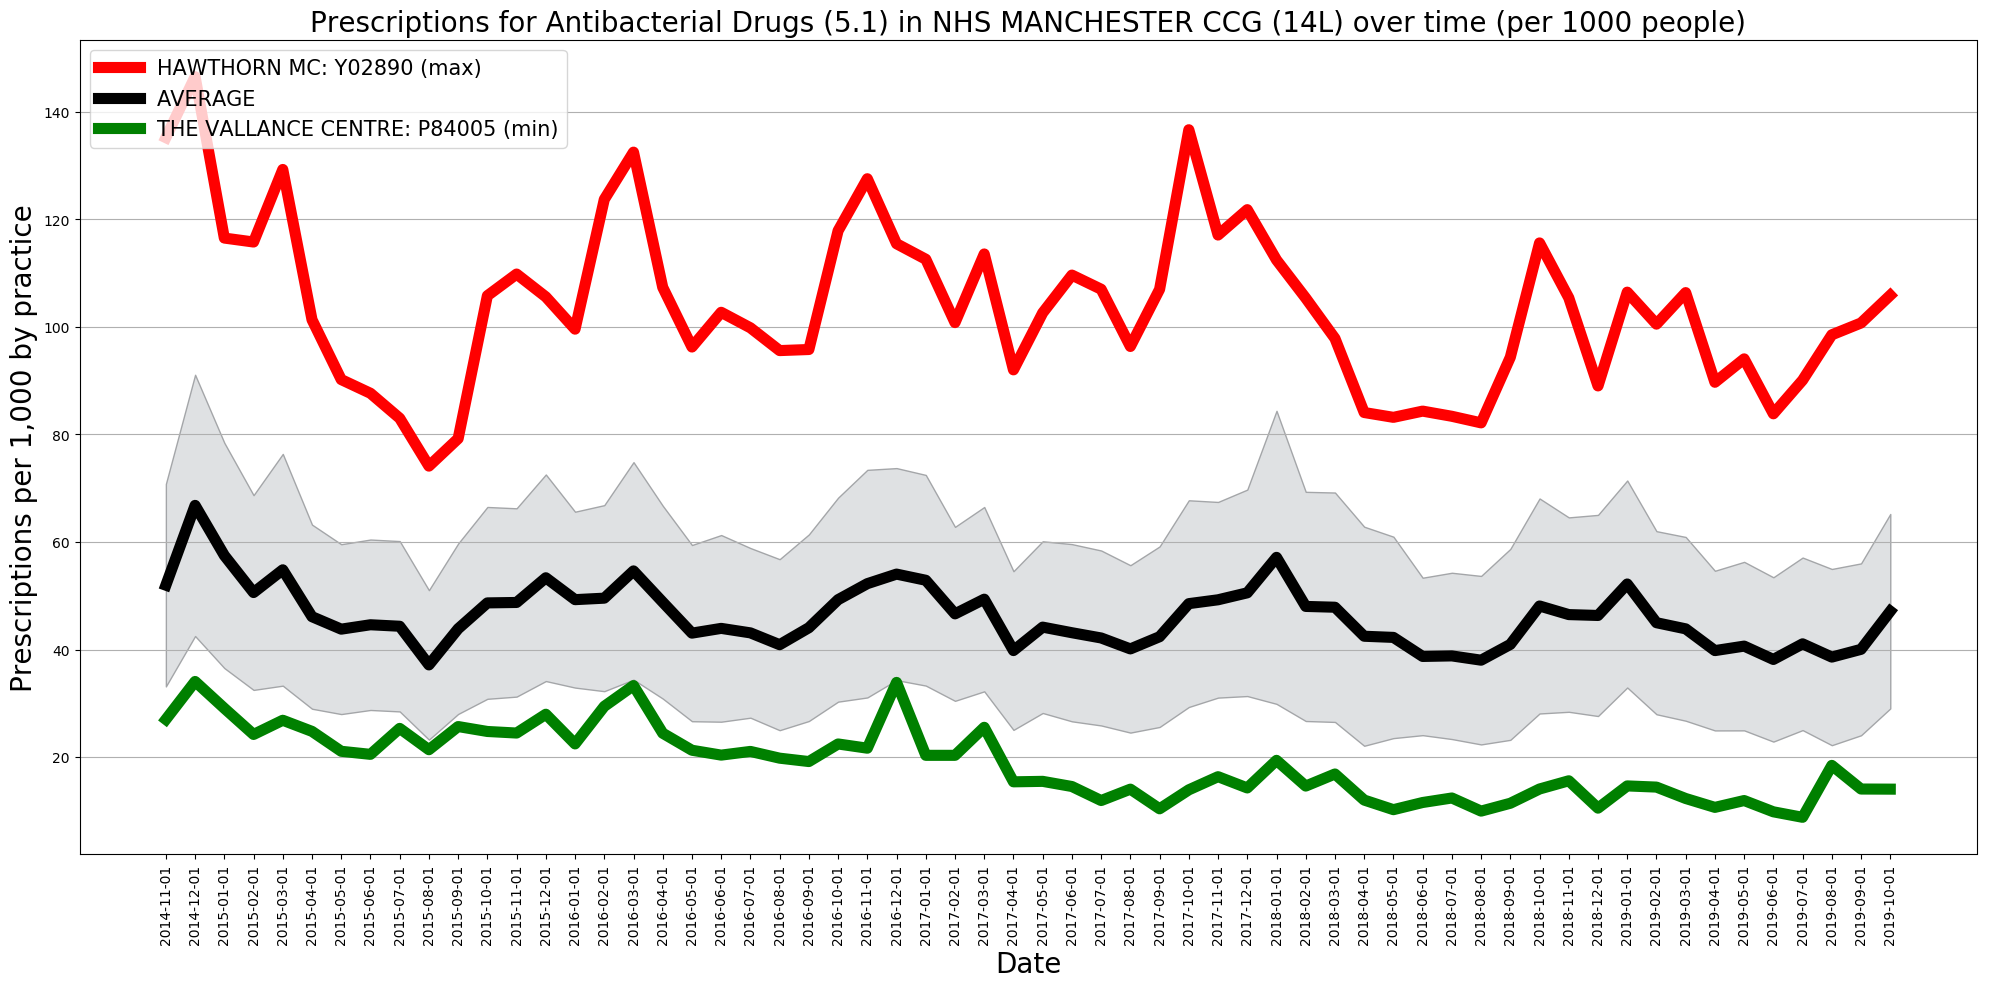

In [80]:
prescriptionsPlot(demomode=True)

Demomode active!
Loading ExampleData.csv
Generating example plot: CCG = 'NHS Manchester CCG', BNF = 'Antibacterial Drugs', Centre = LADYBARN GROUP PRACTICE


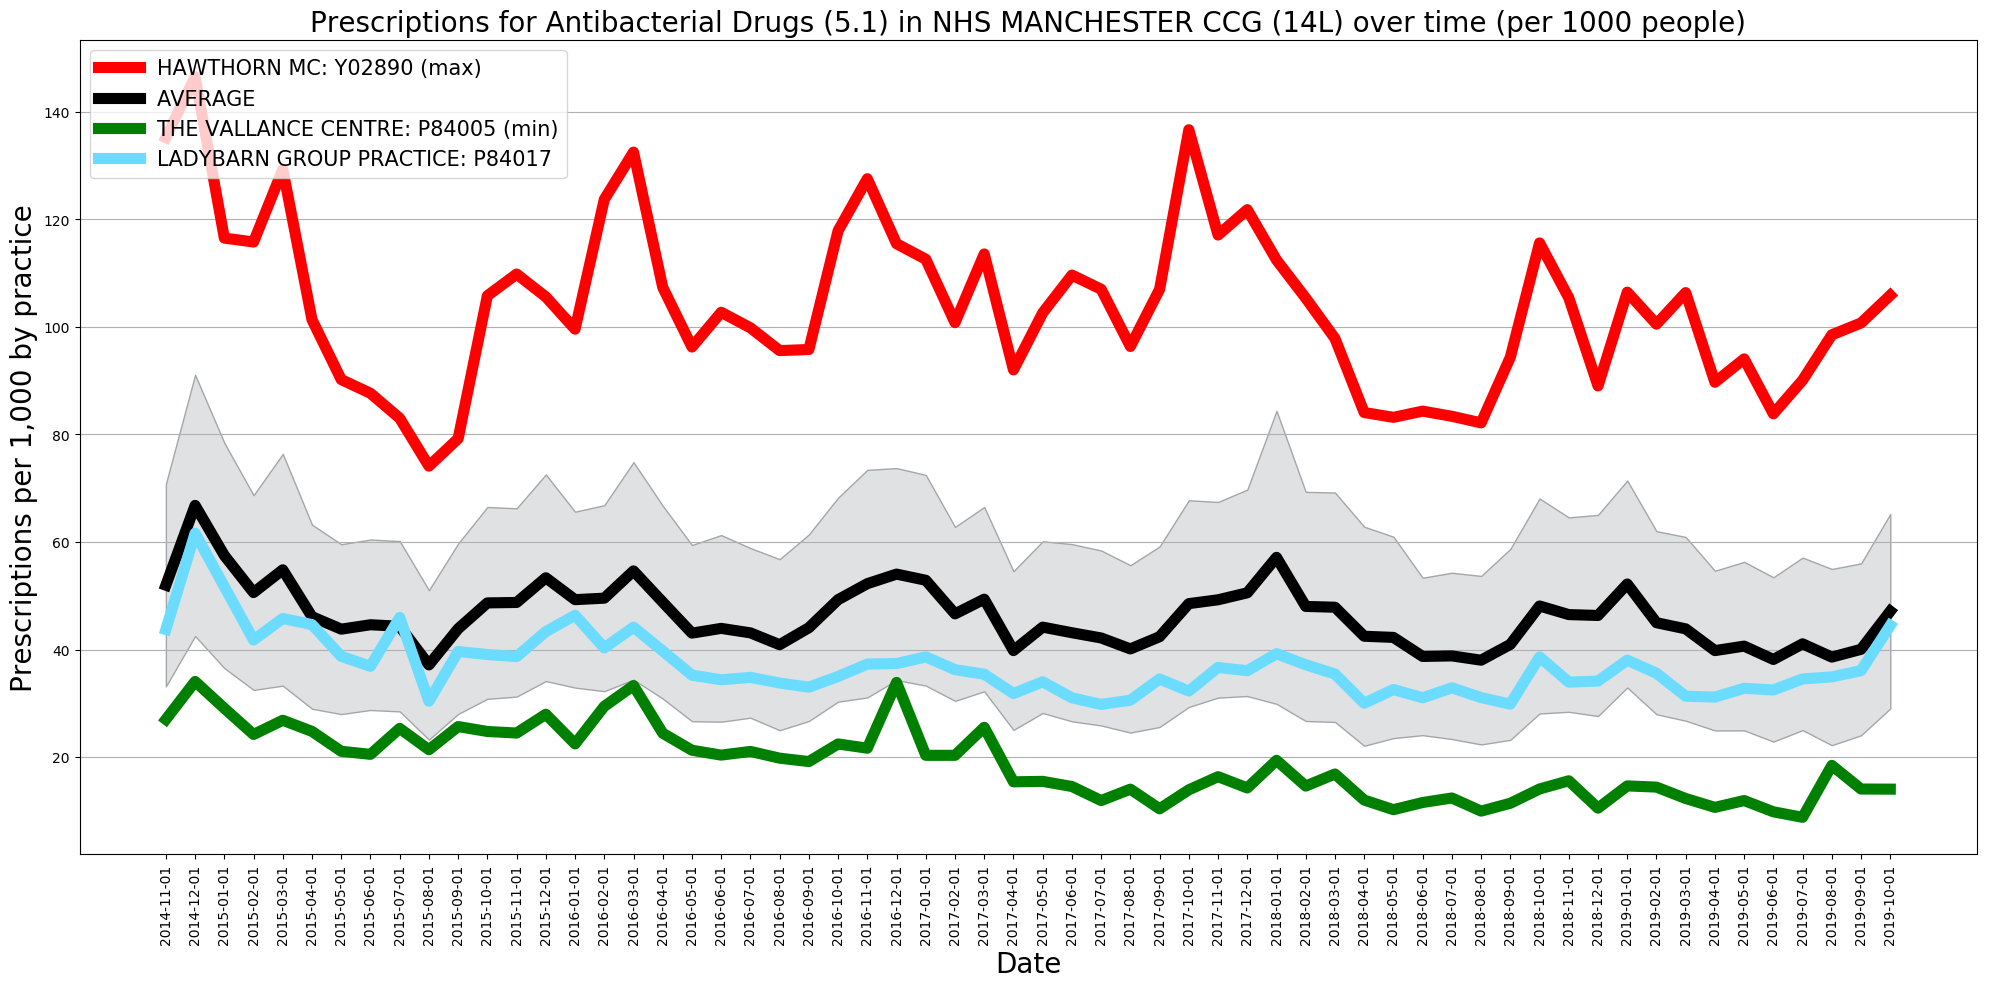

In [81]:
prescriptionsPlot(demomode=True, centre='lady')

### 5) Running the function searching the API for the Manchester CCG and Antibacterial Drugs BNF using their codes.

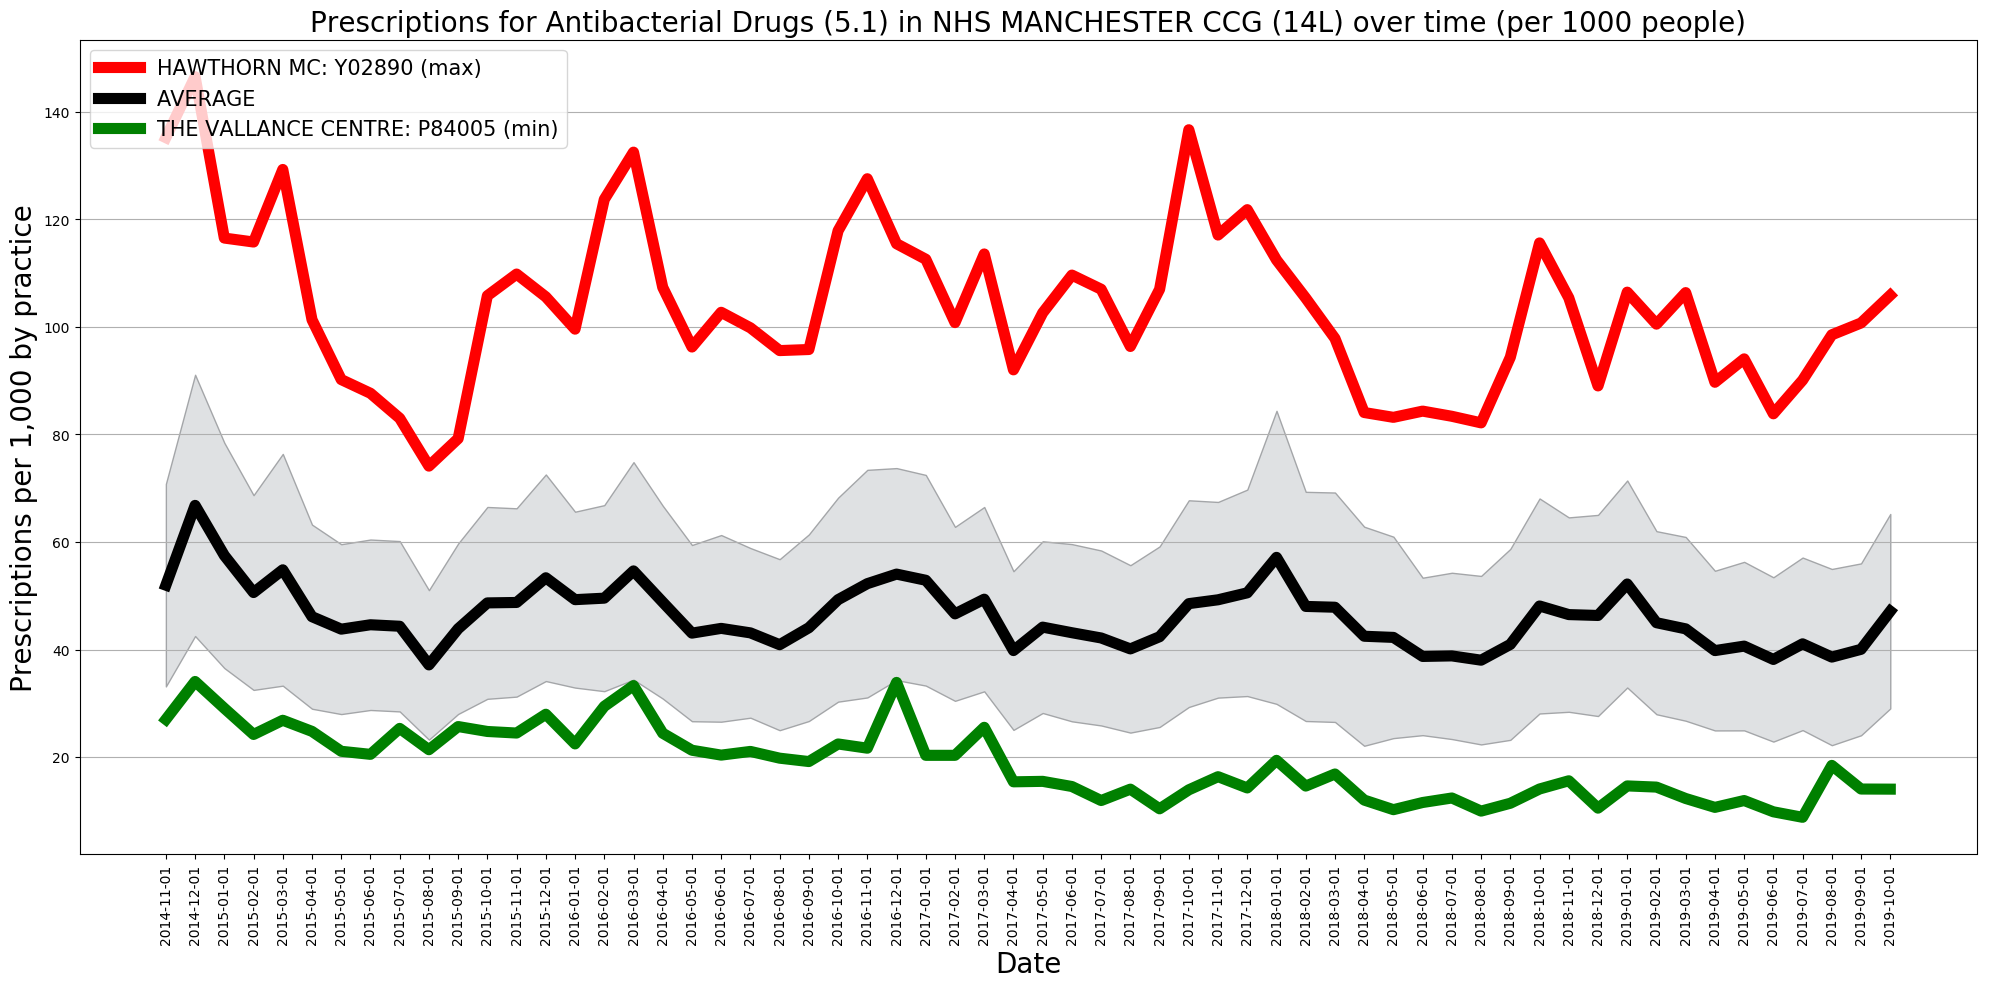

In [82]:
prescriptionsPlot(CCG='14L', BNF='5.1')

*Here can see plot showing the average values and standard deviation pertaining to the number of antibacterial drugs prescribed each month across all centers within the NHS Manchester CCG. Additionally the plot automatically includes the relevent values for the two centres within the selected CCG with the most extreme average values.* 

## 6) Running the function searching the API for the Manchester CCG and Antibacterial Drugs BNF using automatic partial matching of their names.

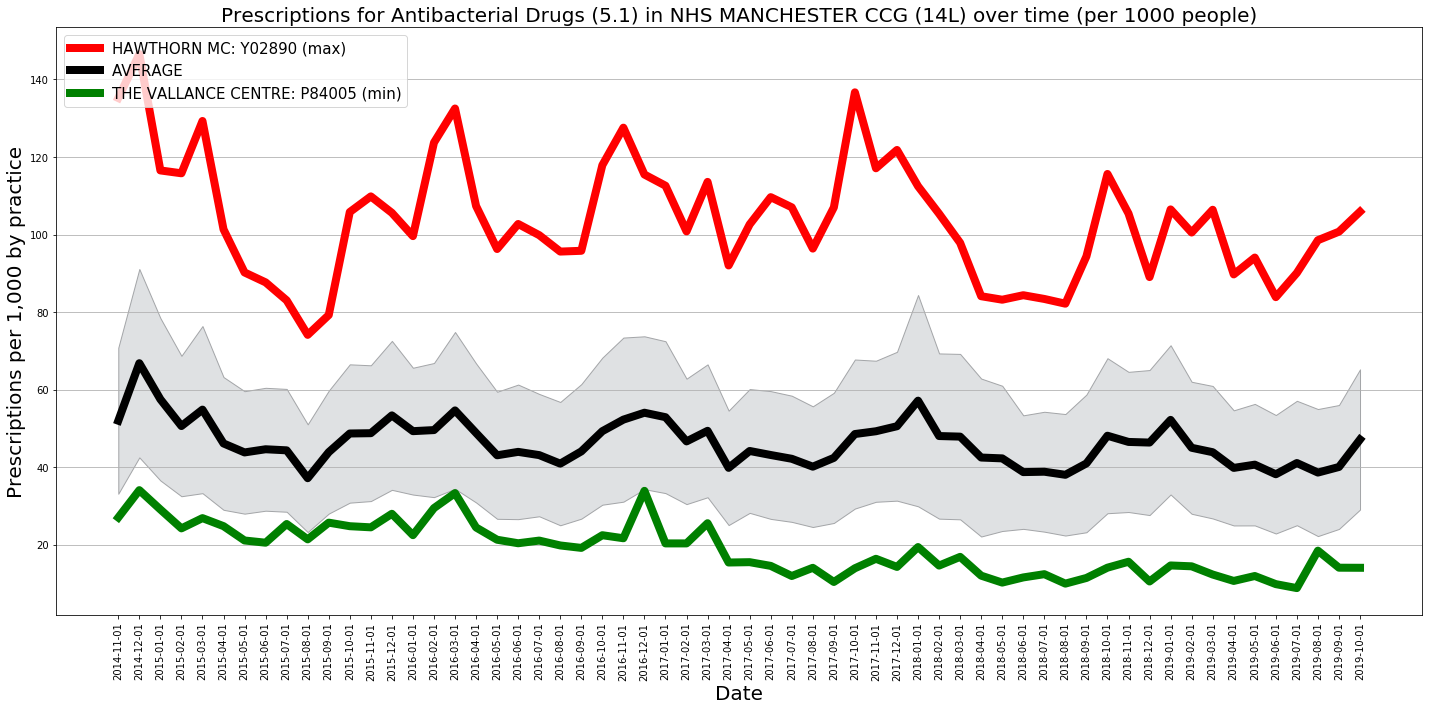

In [11]:
prescriptionsPlot(CCG='manc', BNF='antibacterial drugs')

*Here can see that the function includes intelligent partial match API searching to allow it to be used without a knowlege of specific codes. This call produces exactly the same plot as the one above, produced using codes.*

## 7) Adding the values pertaining to a specific centre to a plot. 

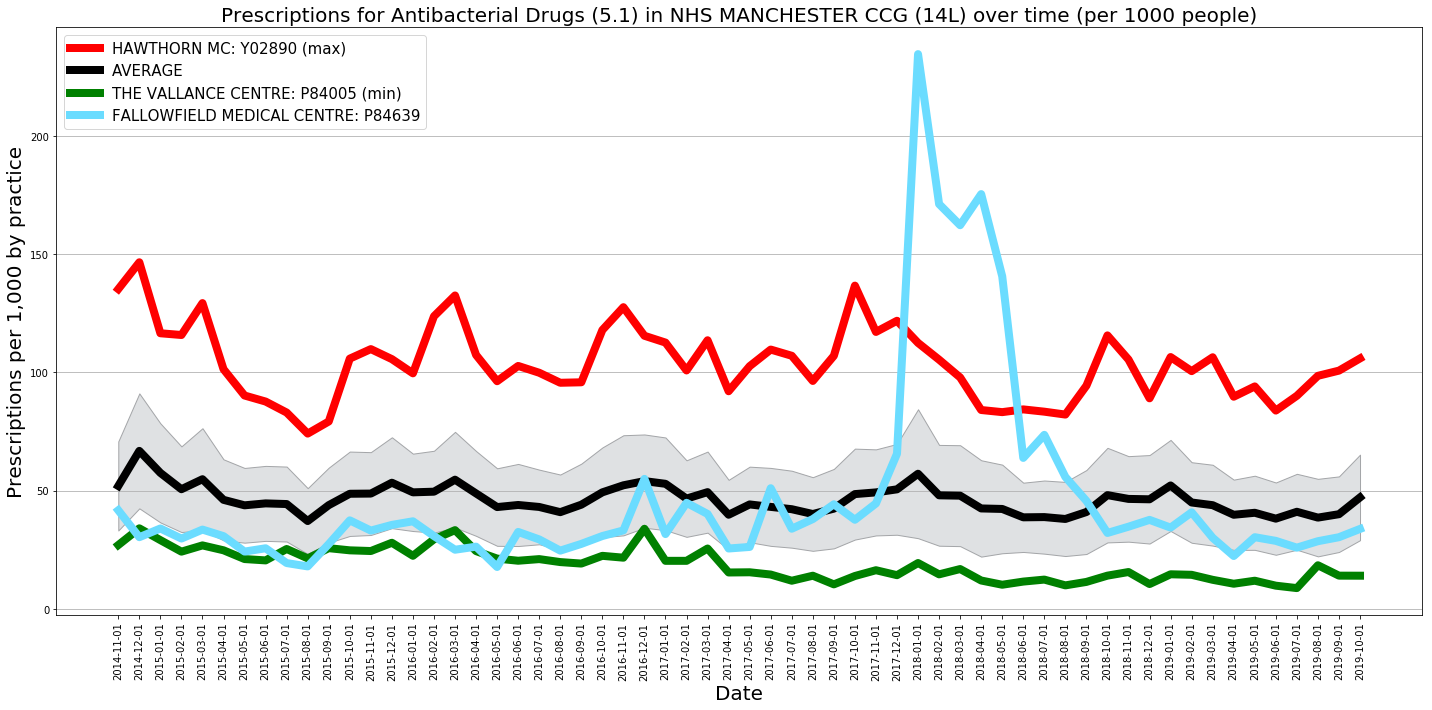

In [12]:
prescriptionsPlot(CCG='manc', BNF='antibacterial drugs', centre='fallowfield')

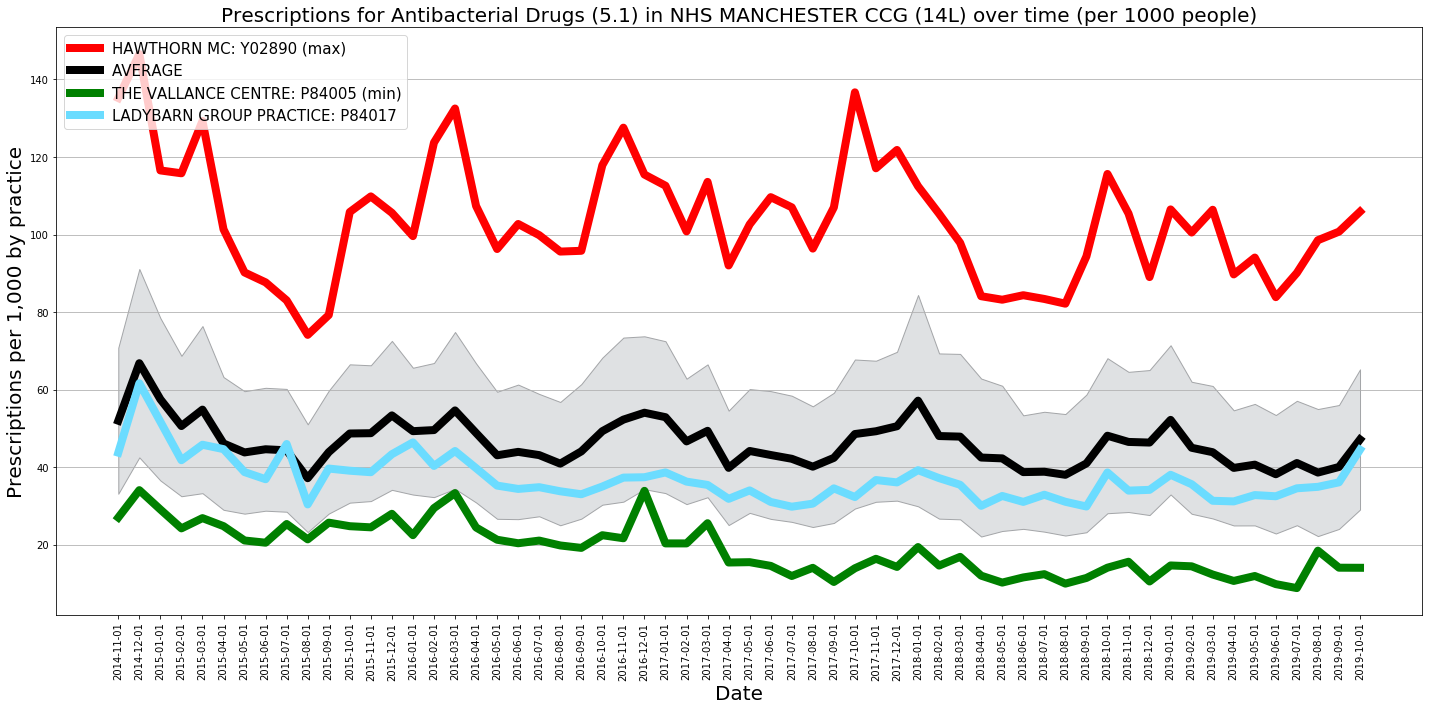

In [13]:
prescriptionsPlot(CCG='manc', BNF='antibacterial drugs', centre='lady')

*The two plots above demonstrate that specifying a centre to the function will add the relevent values for the centre within the selected CCG closest to the search term provided.* 

## 8) Searching for a centre that does not exist within selected CCG.

Invalid centre selection!


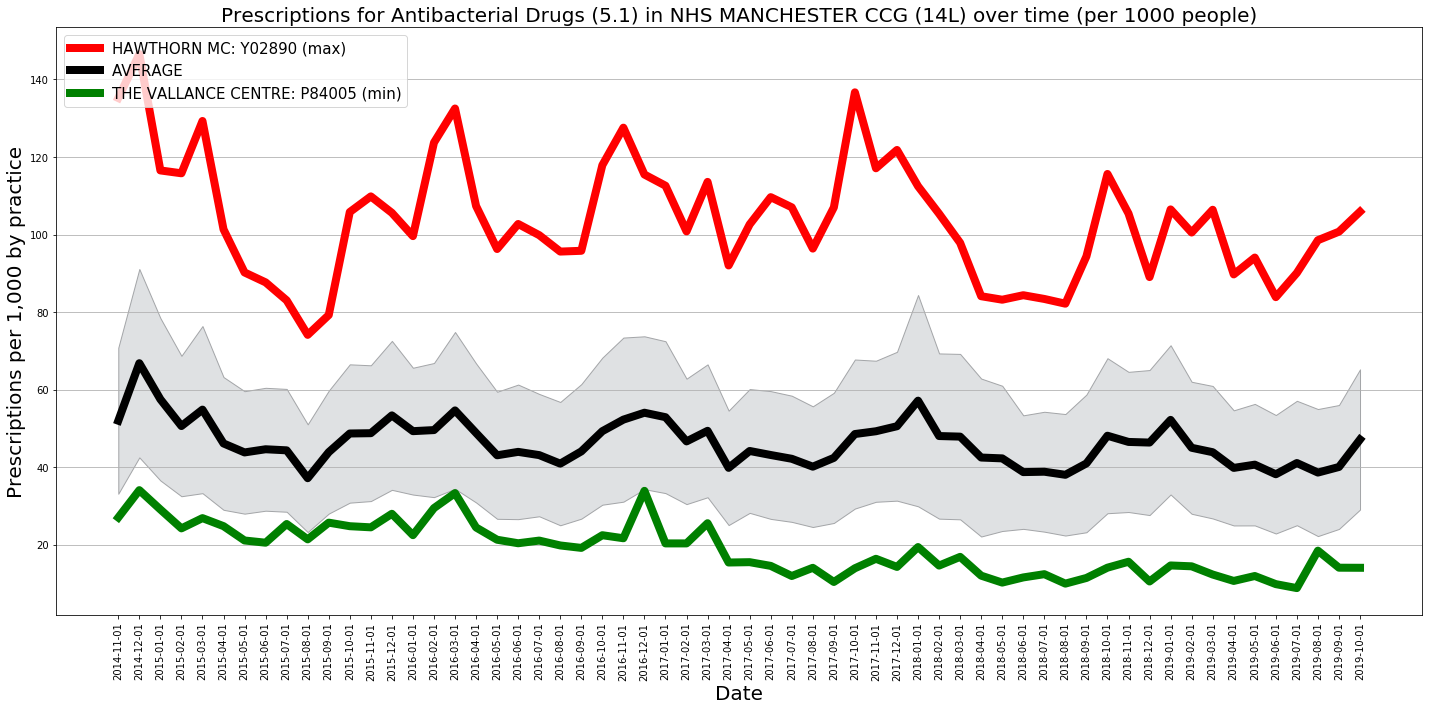

In [14]:
prescriptionsPlot(CCG='manc', BNF='antibacterial drugs', centre='ladywood')

*If no match exists for the specified centre within the selected CCG, the function returns a warning message exaplaining that an invalid entry was provided. It then returns the standard plot showing only the max and min centres as well as the average and standard deviation across all centres.*

## 9) Other examples of the function (different CCG, different BNF, etc.)

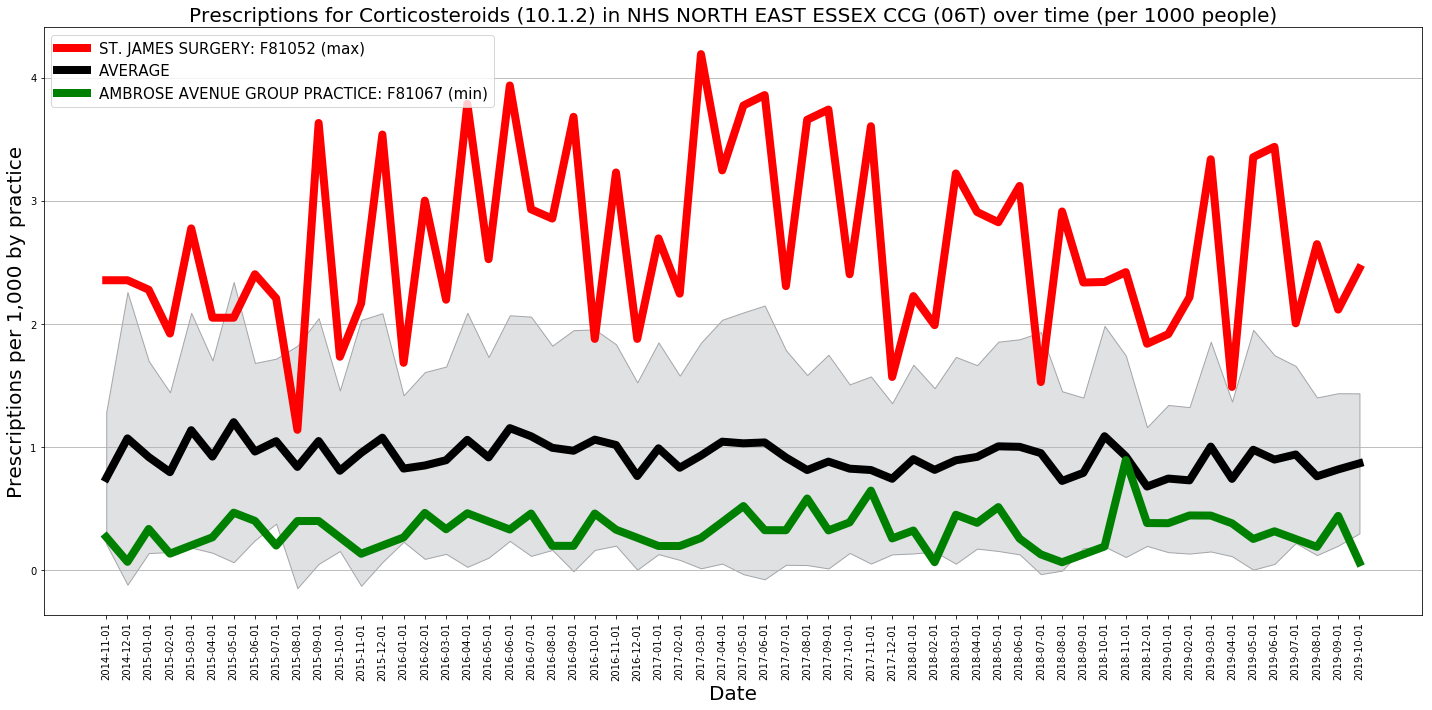

In [15]:
prescriptionsPlot(CCG='essex', BNF='steroids')

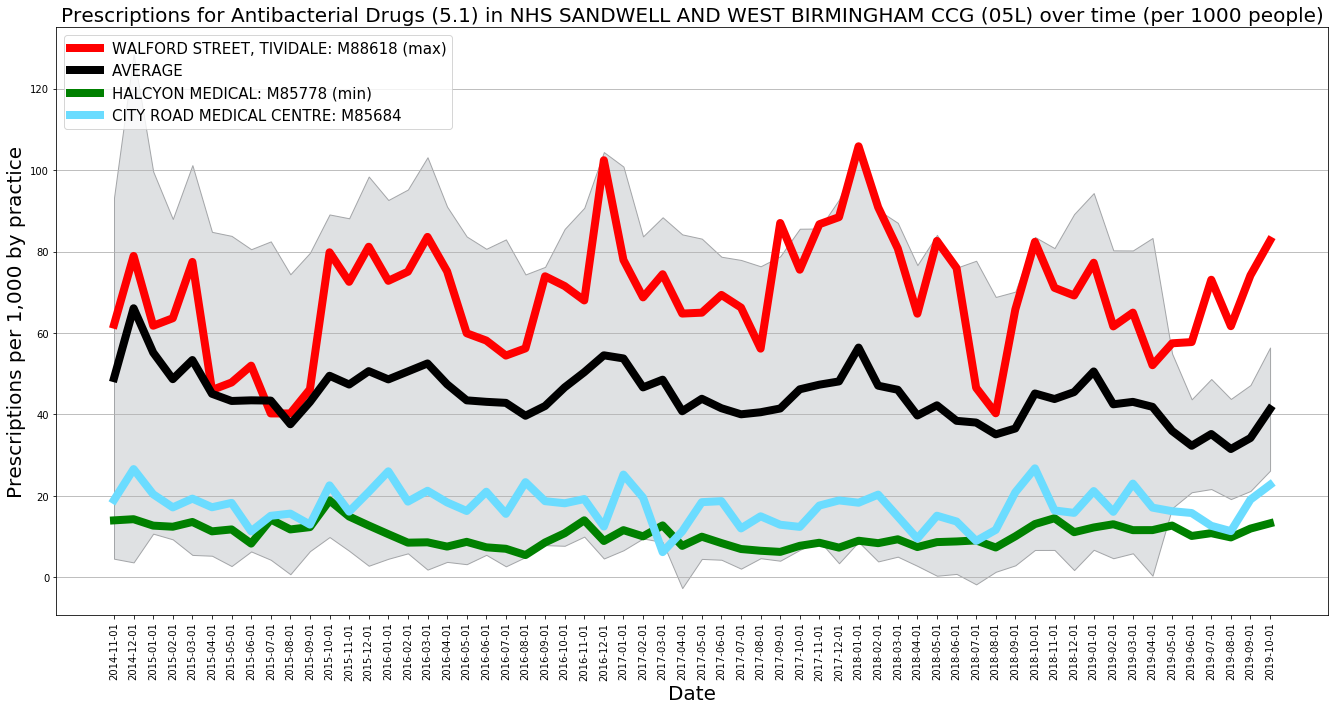

In [16]:
prescriptionsPlot(CCG='birmingham', BNF='5.1', centre='city')